# Analysis of the tensor with zonal averaging 

Understanding the properties of the 3D tensor directly are quite hard. Here we first look at some of the properties of the 2D tensor. 

In [45]:
# load modules 
import xarray as xr
from matplotlib import pyplot as plt
from xgcm import Grid, generate_grid_ds
import numpy as np
%matplotlib inline

params = {
   'axes.labelsize': 12,
   'font.size': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

In [50]:
Tcoarse = xr.open_dataset('./outputs_ncfiles/T_coarse_zonal_50km')
grid = Grid(Tcoarse, periodic='X')

In [51]:
Tcoarse

<xarray.Dataset>
Dimensions:      (YCcoarse: 40, Z: 40)
Coordinates:
  * Z            (Z) float32 -5.0 -15.0 -25.0 -36.0 ... -2727.5 -2830.5 -2933.5
  * YCcoarse     (YCcoarse) float32 25000.0 75000.0 ... 1925000.0 1975000.0
    drF          (Z) float32 ...
    PHrefC       (Z) float32 ...
    hFacCcoarse  (Z, YCcoarse) float32 ...
Data variables:
    T            (Z, YCcoarse) float32 ...
    T_Z          (Z, YCcoarse) float32 ...
    T_Y          (Z, YCcoarse) float32 ...
    VT           (Z, YCcoarse) float32 ...
    WT           (Z, YCcoarse) float32 ...
    VpTp         (Z, YCcoarse) float32 ...
    WpTp         (Z, YCcoarse) float32 ...

In [53]:
Fbmod = (Tcoarse.VpTp**2 + Tcoarse.WpTp**2)**0.5
gradbmod = (Tcoarse.T_Y**2 + Tcoarse.T_Z**2)**0.5

In [54]:
Fb_perp_mod = (Tcoarse.VpTp*Tcoarse.T_Y + Tcoarse.WpTp*Tcoarse.T_Z) / gradbmod
#Fb_perp_x = Fb_perp_mod*T_x / gradbmod
Fb_perp_y = Fb_perp_mod*Tcoarse.T_Y / gradbmod
Fb_perp_z = Fb_perp_mod*Tcoarse.T_Z / gradbmod

In [55]:
#Fb_para_x = UpTp - Fb_perp_x
Fb_para_y = Tcoarse.VpTp - Fb_perp_y
Fb_para_z = Tcoarse.WpTp - Fb_perp_z

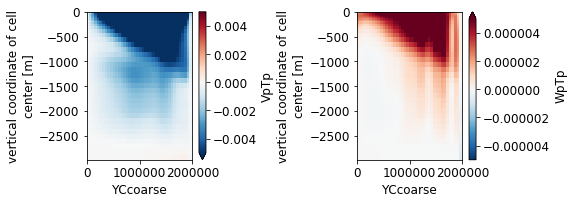

In [57]:
plt.figure(figsize=(8,3))

#plt.subplot(131)
#UpTp.sel(Z=-1000, method='nearest').plot(vmin=-1e-2)

plt.subplot(121)
Tcoarse.VpTp.plot(vmin=-5e-3)

plt.subplot(122)
Tcoarse.WpTp.plot(vmin=-5e-6)
plt.tight_layout() 

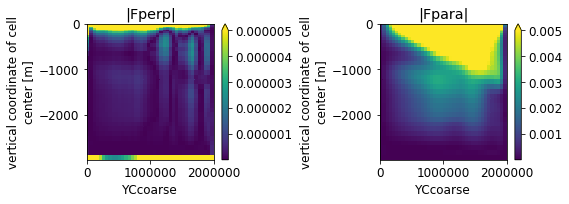

In [58]:
plt.figure(figsize=(8,3))

plt.subplot(121)
((Fb_perp_y**2 + Fb_perp_z**2)**0.5).plot(vmax=5e-6)
plt.title('|Fperp|')

plt.subplot(122)
((Fb_para_y**2 + Fb_para_z**2)**0.5).plot(vmax = 5e-3)
plt.title('|Fpara|')

plt.tight_layout()

In [9]:
# divergences of these fluxes 
divF = grid.interp(grid.diff(VpTp, 'Y', boundary='extend'), 'Y', boundary='extend')/5e3 + \
       -grid.interp(grid.diff(WpTp, 'Z', boundary='extend'), 'Z', boundary='extend')/Model_Tav.drF
    
divFperp = grid.interp(grid.diff(Fb_perp_y, 'Y', boundary='extend'), 'Y', boundary='extend')/5e3 + \
       -grid.interp(grid.diff(Fb_perp_z, 'Z', boundary='extend'), 'Z', boundary='extend')/Model_Tav.drF
        
divFpara = grid.interp(grid.diff(Fb_para_y, 'Y', boundary='extend'), 'Y', boundary='extend')/5e3 + \
       -grid.interp(grid.diff(Fb_para_z, 'Z', boundary='extend'), 'Z', boundary='extend')/Model_Tav.drF 

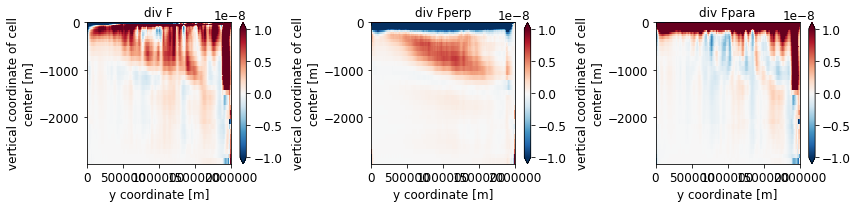

In [10]:
plt.figure(figsize=(12,3))
plt.subplot(131)
divF.plot(vmin=-1e-8)
plt.title('div F')

plt.subplot(132)
divFperp.plot(vmin=-1e-8)
plt.title('div Fperp')

plt.subplot(133)
divFpara.plot(vmin=-1e-8)
plt.title('div Fpara')

plt.tight_layout()

Fpara is 3 orders of magnitude larger than Fperp. However, their divergences are comparable in magnitudes. 

This is all about the buoyancy fluxes only. 

# Mixing angles vs slopes 

In [59]:
Lcoarse = 50e3
diff_tensor_2 = xr.open_dataset('./outputs_ncfiles/diff_tensor_zonal_'+str(int(Lcoarse//1e3))+'km.nc')

In [60]:
Model_Tav = xr.open_dataset('./outputs_ncfiles/Model_Tav.nc')
Trac_Tav = xr.open_dataset('./outputs_ncfiles/Trac_Tav.nc')

In [61]:
Trac_coarse = xr.open_dataset('./outputs_ncfiles/Trac_coarse_zonal_'+str(int(Lcoarse//1e3))+'km')
Vels_coarse = xr.open_dataset('./outputs_ncfiles/Vels_coarse_zonal_'+str(int(Lcoarse//1e3))+'km')
T_coarse    = xr.open_dataset('./outputs_ncfiles/T_coarse_zonal_'+str(int(Lcoarse//1e3))+'km') 

In [62]:
Ycoarse = T_coarse.YCcoarse.data
Z = T_coarse.Z.data

Ypcol = np.append(Ycoarse, Ycoarse[-1]+Lcoarse)-Lcoarse/2
#Xpcol = np.append(Xcoarse, Xcoarse[-1]+Lcoarse)-Lcoarse/2
Zpcol = np.append(Z, Z[-1]) 

In [63]:
[Yg, Zg] = np.meshgrid(Ycoarse, Z)

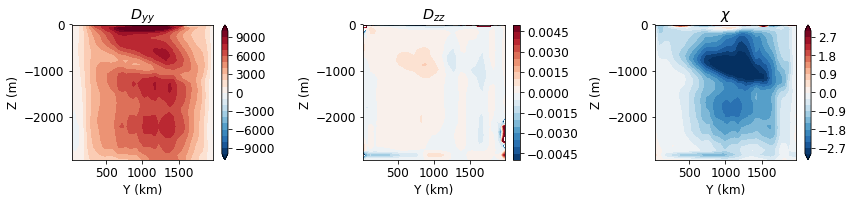

In [82]:
plt.figure(figsize=(12,3))

plt.subplot(131)
plt.contourf(Ycoarse/1e3, Z, diff_tensor_2.eigvalsST.sel(ii=1), vmin=-10e3, vmax=10e3, levels=np.linspace(-10e3, 10e3, 21), cmap='RdBu_r', extend='both')
plt.colorbar()
plt.title(r'$D_{yy}$')
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')

plt.subplot(132)
plt.contourf(Ycoarse/1e3, Z, diff_tensor_2.eigvalsST.sel(ii=0), vmin=-5e-3, vmax=5e-3, levels=np.linspace(-5e-3, 5e-3, 21), cmap='RdBu_r')
plt.colorbar()
plt.title(r'$D_{zz}$')
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')

plt.subplot(133)
plt.contourf(Ycoarse/1e3, Z, diff_tensor_2.AT.sel(i=1, j=0), vmin=-3, vmax=3, levels=np.linspace(-3, 3, 21), cmap='RdBu_r', extend='both')
plt.colorbar()
plt.title(r'$\chi$')
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')

plt.tight_layout()
plt.savefig('2D_tensor_zonal.pdf')

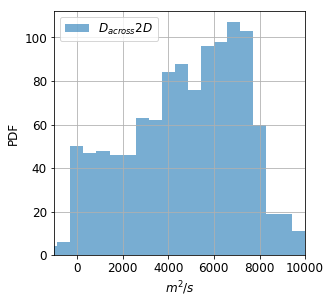

In [65]:
bins = np.linspace(-1e4,3e4,71)
[_,_,_]=diff_tensor_2.eigvalsST.isel(ii=1).where(T_coarse.hFacCcoarse==1.).plot.hist(bins=bins, alpha=0.6, label='$D_{across}2D$')

plt.legend()

plt.xlim([-1000, 10000])
plt.title('')
plt.xlabel('$m^2/s$')
plt.ylabel('PDF')
plt.grid()

In [66]:
vy = diff_tensor_2.eigvecsST.isel(ii=1, k=0)
vz = diff_tensor_2.eigvecsST.isel(ii=1, k=1)

In [67]:
S_iso = -T_coarse.T_Y / T_coarse.T_Z
S_mix = vz / vy

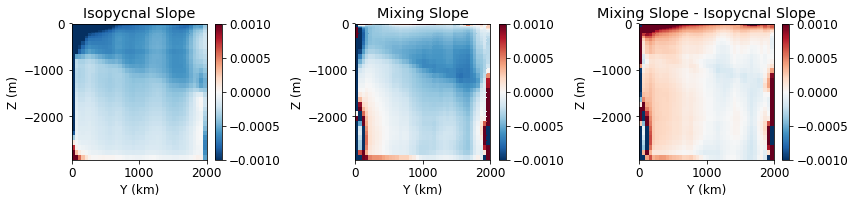

In [69]:
plt.figure(figsize=(12,3))

plt.subplot(131)
plt.pcolormesh(Ypcol/1e3, Zpcol, S_iso, vmin=-0.001, vmax = 0.001, cmap='RdBu_r')
plt.title('Isopycnal Slope')
plt.colorbar()
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')

plt.subplot(132)
plt.pcolormesh(Ypcol/1e3, Zpcol, S_mix, vmin=-0.001, vmax = 0.001, cmap='RdBu_r')
plt.title('Mixing Slope')
plt.colorbar()
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')

plt.subplot(133)
plt.pcolormesh(Ypcol/1e3, Zpcol, (S_mix-S_iso) , vmin=-0.001, vmax = 0.001, cmap='RdBu_r')
plt.title('Mixing Slope - Isopycnal Slope')
plt.colorbar()
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')

plt.tight_layout()
#plt.savefig('2D_slopes.pdf')

The mixing slope and isopycnal slope differ by an O(1e-3). The diffusivity (Dyy) is around O(1e3 ~ 1e4). This implies that residual streamfunction and transport streamfunction differ by O(1). 

Why do the mixing angle and isopycnal slopes differ so much? 
- Dynamical result of variance transport or the internal diffusivity in the model. 
- The mixing slope is estimated for tracers with a source. 

#### Recontruct fluxes

In [70]:
def flux_reconstruct_2D(tensor, flux, grads):

    recVflux = -(tensor.sel(i=0, j=0)*grads.dCdy + tensor.sel(i=0, j=1)*grads.dCdz)
    recWflux = -(tensor.sel(i=1, j=0)*grads.dCdy + tensor.sel(i=1, j=1)*grads.dCdz)

    errV = np.abs(flux.VpCp - recVflux)/np.abs(flux.VpCp)
    errW = np.abs(flux.WpCp - recWflux)/np.abs(flux.WpCp)
    
    flux_rec=xr.Dataset({'VpCp':recVflux, 'WpCp':recWflux,
                                'errV':errV, 'errW':errW})
    
    return flux_rec

In [71]:
def flux_reconstruct_2D_deep(tensor, flux, grads):

    recVflux1 = -(tensor.sel(i=0, j=0)*grads.dCdy) 
    recVflux2 = -(tensor.sel(i=0, j=1)*grads.dCdz)
    recVflux = -(tensor.sel(i=0, j=0)*grads.dCdy + tensor.sel(i=0, j=1)*grads.dCdz)
    
    recWflux1 = -(tensor.sel(i=1, j=0)*grads.dCdy)
    recWflux2 = -(tensor.sel(i=1, j=1)*grads.dCdz)
    recWflux = -(tensor.sel(i=1, j=0)*grads.dCdy + tensor.sel(i=1, j=1)*grads.dCdz)

    errV = np.abs(flux.VpCp - recVflux)/np.abs(flux.VpCp)
    errW = np.abs(flux.WpCp - recWflux)/np.abs(flux.WpCp)
    
    flux_rec=xr.Dataset({'VpCp':recVflux, 'WpCp':recWflux,
                         'VpCp1':recVflux1, 'VpCp2':recVflux2,
                         'WpCp1':recWflux1, 'WpCp2':recWflux2,
                                'errV':errV, 'errW':errW})
    
    return flux_rec

In [72]:
fluxT = xr.Dataset({'VpCp':T_coarse.VpTp, 'WpCp':T_coarse.WpTp})
gradT = xr.Dataset({'dCdy':T_coarse.T_Y, 'dCdz':T_coarse.T_Z})

In [73]:
frbS2 = flux_reconstruct_2D(diff_tensor_2.ST, fluxT, gradT)
frbA2 = flux_reconstruct_2D(diff_tensor_2.AT, fluxT, gradT)

In [74]:
frbS2deep = flux_reconstruct_2D_deep(diff_tensor_2.ST, fluxT, gradT)
frbA2deep = flux_reconstruct_2D_deep(diff_tensor_2.AT, fluxT, gradT)

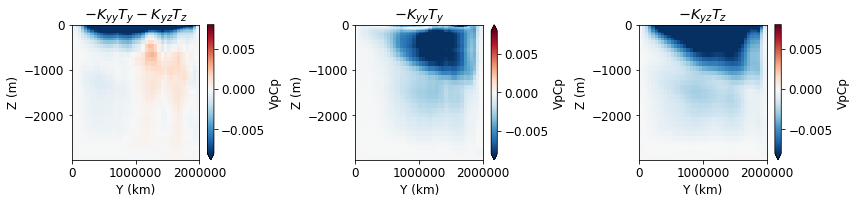

In [83]:
plt.figure(figsize=(12,3))

plt.subplot(131)
(frbS2).VpCp.plot(vmin = -8e-3)
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')
plt.title('$-K_{yy}T_y - K_{yz}T_z$')

plt.subplot(132)
(frbA2).VpCp.plot(vmin = -8e-3)
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')
plt.title('$-K_{yy}T_y$')

plt.subplot(133)
(frbS2 + frbA2).VpCp.plot(vmin = -8e-3)
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')
plt.title('$-K_{yz}T_z$')

plt.tight_layout()

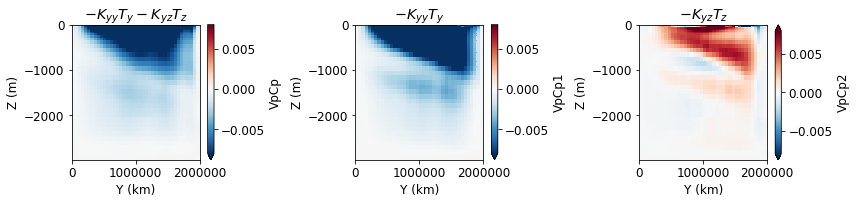

In [75]:
plt.figure(figsize=(12,3))

plt.subplot(131)
(frbS2deep + frbA2deep).VpCp.plot(vmin = -8e-3)
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')
plt.title('$-K_{yy}T_y - K_{yz}T_z$')

plt.subplot(132)
(frbS2deep + frbA2deep).VpCp1.plot(vmin = -8e-3)
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')
plt.title('$-K_{yy}T_y$')

plt.subplot(133)
(frbS2deep + frbA2deep).VpCp2.plot(vmin = -8e-3)
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')
plt.title('$-K_{yz}T_z$')

plt.tight_layout()
#plt.savefig('2D_horz_buoy_flux_split.pdf')

Different streamfunctions 

In [76]:
psi_QGTEM = T_coarse.VpTp/T_coarse.T_Z
psi_PE = (T_coarse.VpTp*T_coarse.T_Z - T_coarse.WpTp*T_coarse.T_Y
         )/ (T_coarse.T_Y**2 + T_coarse.T_Z**2)

In [77]:
psi_Stensor = (frbS2.VpCp*T_coarse.T_Z - frbS2.WpCp*T_coarse.T_Y)/ (T_coarse.T_Y**2 + T_coarse.T_Z**2)
psi_Atensor = (frbA2.VpCp*T_coarse.T_Z - frbA2.WpCp*T_coarse.T_Y)/ (T_coarse.T_Y**2 + T_coarse.T_Z**2)

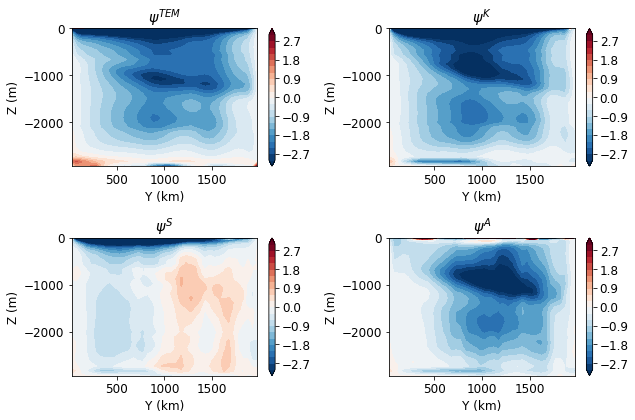

In [81]:
plt.figure(figsize=(9,6))

plt.subplot(221)
plt.contourf(Ycoarse/1e3, Z, psi_PE, vmin=-3, vmax=3, levels=np.linspace(-3, 3,21), cmap='RdBu_r', extend='both')
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')
plt.title('$\psi^{TEM}$')
plt.colorbar()
plt.tight_layout( )

plt.subplot(222)
plt.contourf(Ycoarse/1e3, Z, (psi_Atensor+psi_Stensor), vmin=-3, vmax=3, levels=np.linspace(-3, 3,21), 
             cmap='RdBu_r', extend='both')
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')
plt.title('$\psi^K$')
plt.colorbar()
plt.tight_layout( )

plt.subplot(223)
plt.contourf(Ycoarse/1e3, Z, (psi_Stensor), vmin=-3, vmax=3, levels=np.linspace(-3, 3,21), cmap='RdBu_r', extend='both')
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')
plt.title('$\psi^S$')
plt.colorbar()

plt.subplot(224)
plt.contourf(Ycoarse/1e3, Z, (psi_Atensor), vmin=-3, vmax=3, levels=np.linspace(-3, 3,21), cmap='RdBu_r', extend='both')
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')
plt.title('$\psi^A$')
plt.colorbar()

plt.tight_layout()
plt.savefig('2D_tensor_psi_zonal.pdf')

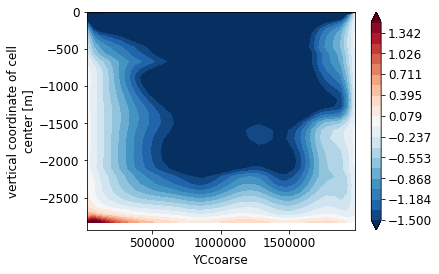

In [43]:
psi_QGTEM.plot.contourf(vmin=-1.5, levels=20)

## Different K_GMs. 

In [159]:
S = -T_coarse_2D.T_Y/T_coarse_2D.T_Z

In [160]:
Kgm_TEM = psi_PE/S
Kgm_A   = psi_Atensor/S
Kgm_K   = (psi_Atensor+psi_Stensor)/S

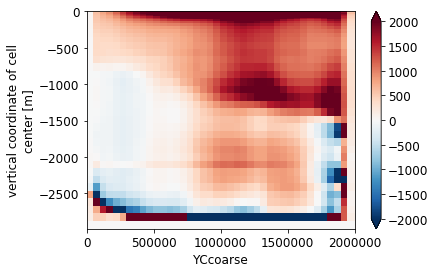

In [163]:
Kgm_TEM.plot(vmin=-2e3)

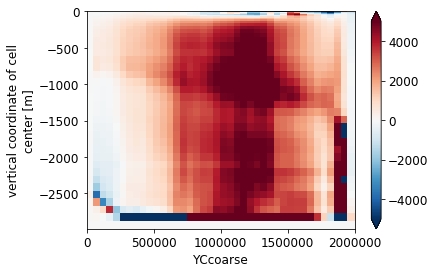

In [165]:
Kgm_A.plot(vmin=-5e3)

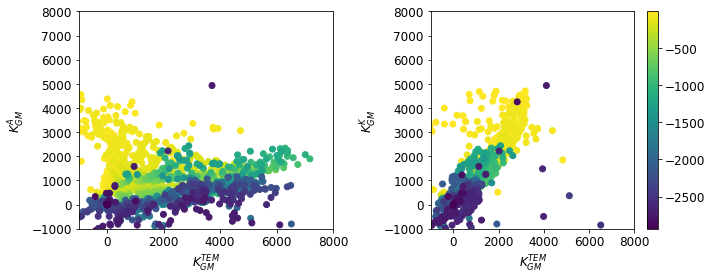

In [193]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.scatter(Kgm_A, Kgm_TEM, c=Zg)
plt.xlim([-1000, 8e3])
plt.ylim([-1000, 8e3])
plt.xlabel('$K_{GM}^{TEM}$')
plt.ylabel('$K_{GM}^{A}$')

plt.subplot(122)
plt.scatter(Kgm_K, Kgm_TEM, c=Zg)
plt.xlim([-1000, 8e3])
plt.ylim([-1000, 8e3])
plt.xlabel('$K_{GM}^{TEM}$')
plt.ylabel('$K_{GM}^{K}$')
plt.colorbar()


plt.tight_layout()
plt.savefig('2D_KGM.pdf')

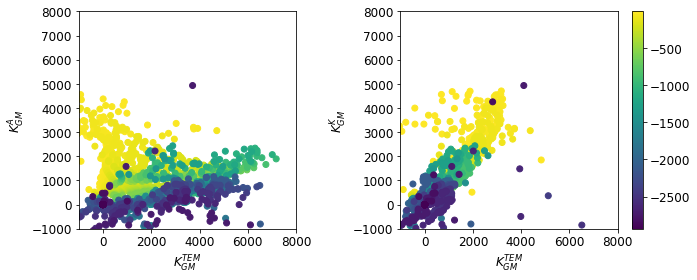

In [201]:
fig,ax = plt.subplots(1,2,figsize=(10,4))

ax[0].scatter(Kgm_A, Kgm_TEM, c=Zg)
ax[0].set_xlim([-1000, 8e3])
ax[0].set_ylim([-1000, 8e3])
ax[0].set_xlabel('$K_{GM}^{TEM}$')
ax[0].set_ylabel('$K_{GM}^{A}$')
ax[0].set_aspect('equal')

im = ax[1].scatter(Kgm_K, Kgm_TEM, c=Zg)
ax[1].set_xlim([-1000, 8e3])
ax[1].set_ylim([-1000, 8e3])
ax[1].set_xlabel('$K_{GM}^{TEM}$')
ax[1].set_ylabel('$K_{GM}^{K}$')
ax[1].set_aspect('equal')

fig.colorbar(im)

plt.tight_layout()
plt.savefig('2D_KGM.pdf')

(-1000, 8000.0)

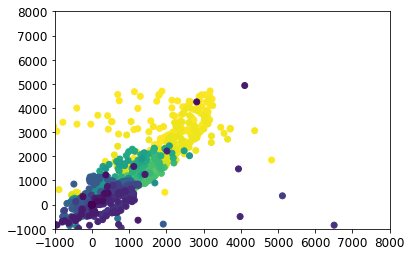

In [186]:
plt.scatter(Kgm_K, Kgm_TEM, c=Zg)
plt.xlim([-1000, 8e3])
plt.ylim([-1000, 8e3])